In [1]:
import os

import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import sklearn as sk

import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   try:
#     # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
# Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), 'Physical GPUs,', len(logical_gpus), 'Logical GPUs')
    except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
        print(e)

In [3]:
CATEGORIES = ['cats', 'dogs']
TRAINDIR = '../Dataset/training_set/training_set/'
TESTDIR = '../Dataset/test_set/test_set/'

IMAGE_SHAPE = (80, 80)
BATCH_LEN = 1000

X_train = []
Y_train = []

In [4]:
def train_data_load():
    for index in [0, 1]:
        X = []
        gen = ImageDataGenerator(    
            rotation_range= 45,
            height_shift_range= .2,
            width_shift_range= .2,
            zoom_range= .2,
            vertical_flip= True,
            horizontal_flip= True,
            fill_mode= 'reflect',
        )

        category = CATEGORIES[index]
        path = os.path.join(TRAINDIR, category)
        for file in glob.glob(path + '/*.jpg'):
            img = io.imread(file, as_gray= True)
            img = cv2.resize(img, IMAGE_SHAPE)
            X.append(img)
            
        X = np.array(X)
        X = tf.expand_dims(X, axis= -1)
        print(X.shape)
        
        count = 0
        for batch in gen.flow(X, batch_size= 32):
            for img in batch:
                X_train.append(img)
                Y_train.append(index)
                
            count += 1
            if count >= BATCH_LEN:
                break
                
        for img in X:
            X_train.append(img)
            Y_train.append(index)
        

In [5]:
train_data_load()

(4000, 80, 80, 1)
(4005, 80, 80, 1)


In [6]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [7]:
X_train, Y_train = sk.utils.shuffle(X_train, Y_train)

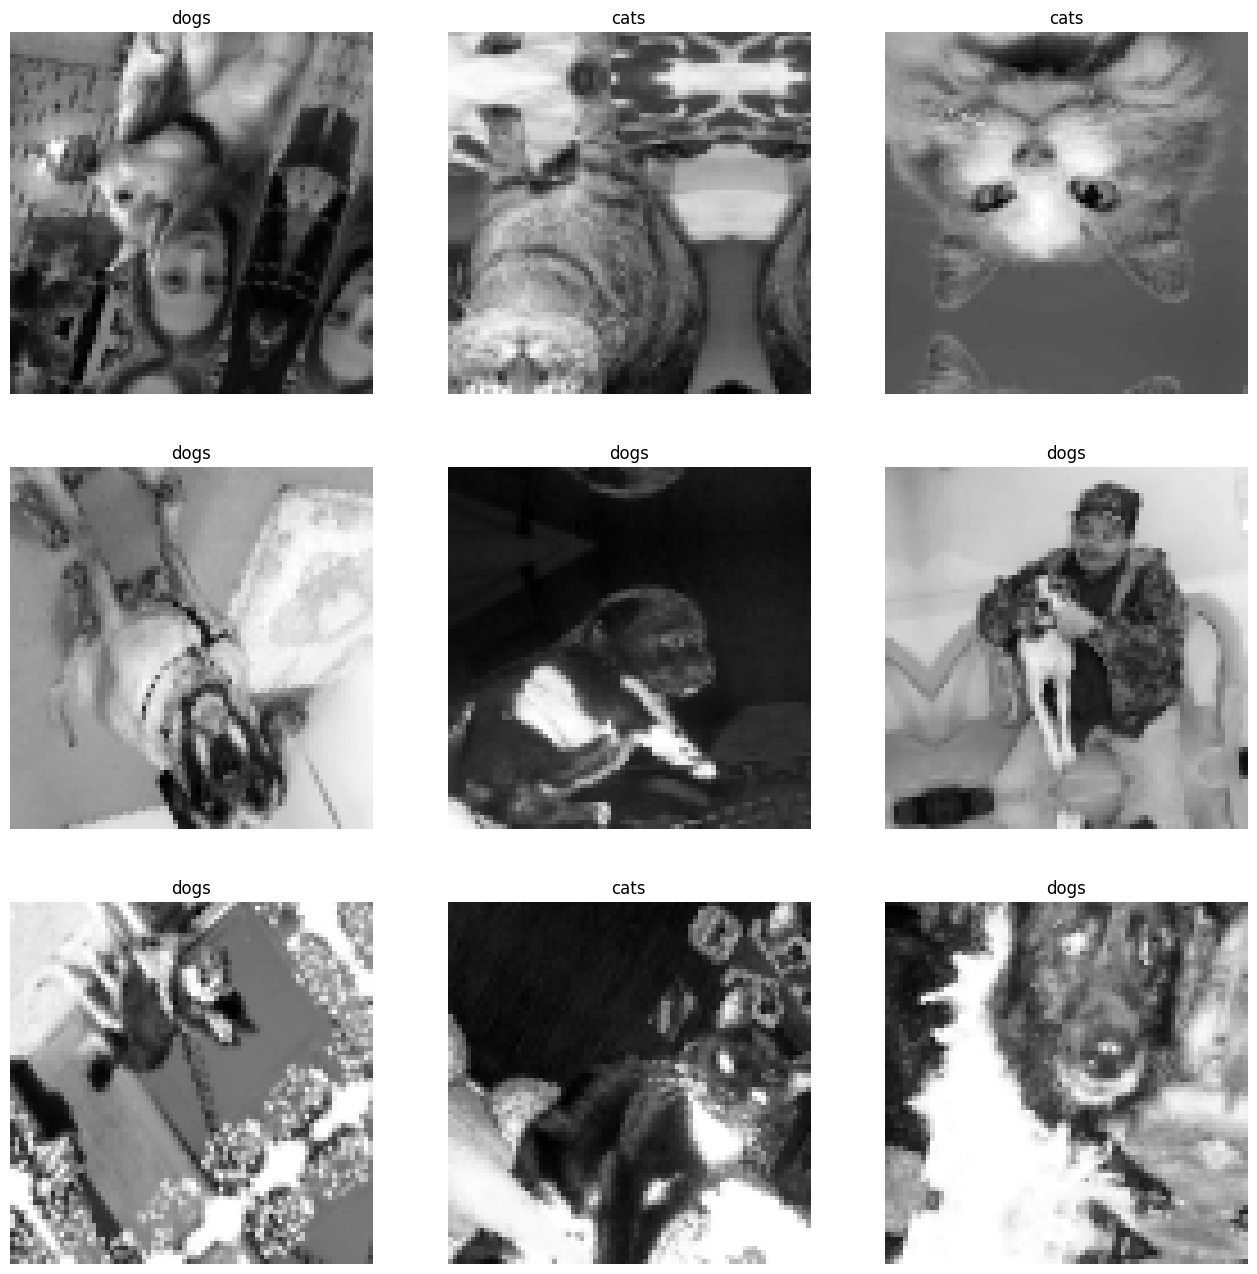

In [8]:
fig, ax = plt.subplots(3, 3, figsize= [16, 16])

for i in range(3):
    for j in range(3):
        indx = np.random.randint(0, len(Y_train))
        ax[i, j].imshow(X_train[indx], cmap= 'gray')
        ax[i, j].set_title(CATEGORIES[Y_train[indx]])
        ax[i, j].axis('off')

In [9]:
X_test = []
Y_test = []

def create_testing_data():
        for category in CATEGORIES:
            path = os.path.join(TESTDIR, category + '/*.jpg')
            label = CATEGORIES.index(category)
            for p in glob.glob(path):
                img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, IMAGE_SHAPE)
                X_test.append(img)
                Y_test.append(label)
            
create_testing_data()
X_test = np.array(X_test)
Y_test = np.array(Y_test)

X_test, Y_test = sk.utils.shuffle(X_test, Y_test)
X_test = tf.expand_dims(X_test, axis= -1)


In [10]:
Y_train = keras.utils.to_categorical(Y_train, 2)
Y_test = keras.utils.to_categorical(Y_test, 2)

In [11]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), strides= (1, 1), input_shape= X_train.shape[1:], activation= 'relu'),
    keras.layers.MaxPool2D(pool_size= (3, 3)),

    keras.layers.Conv2D(24, (3, 3), strides= (2, 2), activation= 'relu'),
    keras.layers.MaxPool2D(pool_size= (2, 2)),

    # tf.keras.layers.GlobalMaxPool2D(),
    tf.keras.layers.GlobalAveragePooling2D(),

    keras.layers.Dense(16, activation= 'relu'),
    keras.layers.Dense(8, activation= 'relu'),
    keras.layers.Dense(2, activation= 'softmax')

])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 26, 26, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 24)        6936      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 24)          0         
 g2D)                                                            
                                                                 
 global_average_pooling2d (  (None, 24)                0         
 GlobalAveragePooling2D)                                         
                                                        

In [12]:
X_train.shape, Y_train.shape

((71816, 80, 80, 1), (71816, 2))

In [13]:
X_train.min()

0.0

In [14]:
model.compile(optimizer= keras.optimizers.Adam(), loss= keras.losses.categorical_crossentropy, metrics=['accuracy'])

hist = model.fit(X_train, Y_train, batch_size= 32, epochs= 10, validation_data= (X_test, Y_test))

Epoch 1/10
2245/2245 [==============================] - 95s 41ms/step - loss: 0.6758 - accuracy: 0.5713 - val_loss: 89.3985 - val_accuracy: 0.5106
Epoch 2/10
2245/2245 [==============================] - 91s 40ms/step - loss: 0.6549 - accuracy: 0.6153 - val_loss: 78.3247 - val_accuracy: 0.5497
Epoch 3/10
2245/2245 [==============================] - 89s 40ms/step - loss: 0.6472 - accuracy: 0.6249 - val_loss: 58.9928 - val_accuracy: 0.5596
Epoch 4/10
2245/2245 [==============================] - 90s 40ms/step - loss: 0.6380 - accuracy: 0.6351 - val_loss: 64.6397 - val_accuracy: 0.5601
Epoch 5/10
2245/2245 [==============================] - 89s 40ms/step - loss: 0.6291 - accuracy: 0.6464 - val_loss: 94.6239 - val_accuracy: 0.5274
Epoch 6/10
2245/2245 [==============================] - 90s 40ms/step - loss: 0.6189 - accuracy: 0.6572 - val_loss: 92.6034 - val_accuracy: 0.5497
Epoch 7/10
2245/2245 [==============================] - 90s 40ms/step - loss: 0.6097 - accuracy: 0.6692 - val_loss: 83

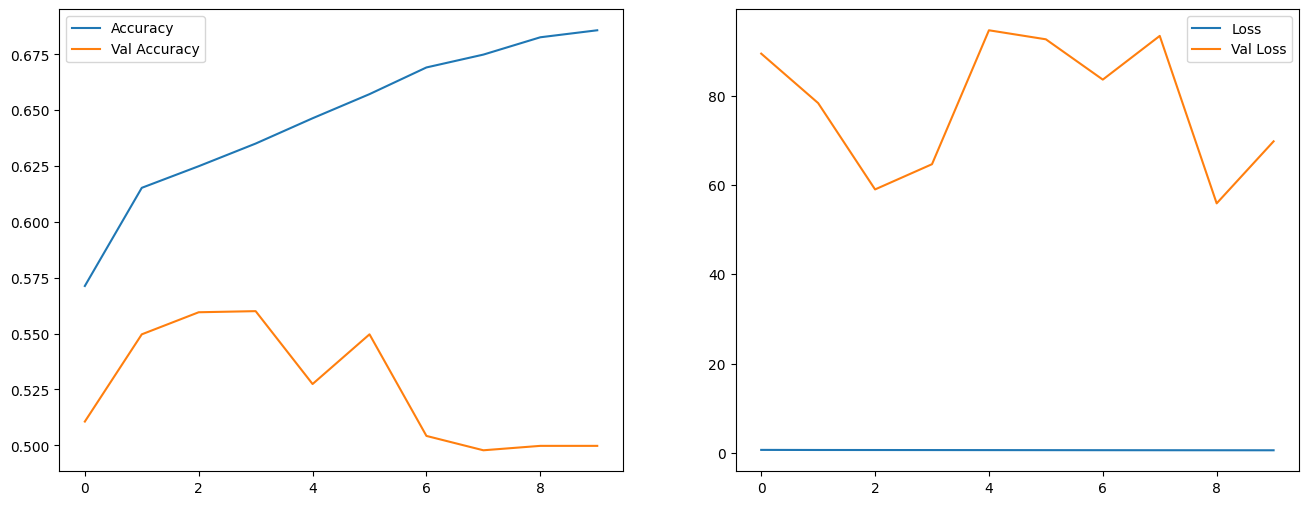

In [15]:
plt.figure(figsize= (16, 6))
plt.subplot(1, 2, 1)

plt.plot(hist.history['accuracy'], label= 'Accuracy')
plt.plot(hist.history['val_accuracy'], label= 'Val Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label= 'Loss')
plt.plot(hist.history['val_loss'], label= 'Val Loss')
plt.legend()

plt.show()